# EMG Data & Visual Exploration (NB, GM, SVM, K-Means)

In this notebook we explore the sEMG dataset for different hand gestures. We perform the following steps:

* Preprocess and clean up our dataset
* Leverage signal processing to smooth out the dataset
* Perform a variety of classification techniques

In [3]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io
import scipy
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [4]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [5]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

dataset = pd.concat(dfs)
print("Dimensions", dataset.shape)
dataset.head()


Dimensions (1800, 3002)


,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,identifier,label
0,0.072198,0.276211,0.429221,0.327214,0.123201,0.097700,0.072198,0.021195,-0.004307,0.174205,...,0.276211,-0.259323,0.072198,1.882814,0.480224,-2.528968,0.097700,0.837247,female_1,Cylindrical
1,0.250710,0.301713,0.199706,0.378218,0.021195,-0.080812,-0.106313,0.021195,0.276211,0.072198,...,-1.304890,0.786244,0.786244,0.939254,1.270775,-0.616346,0.454723,0.021195,female_1,Cylindrical
2,0.123201,0.148703,0.148703,0.123201,-0.004307,-0.157317,-0.029808,0.174205,0.199706,0.250710,...,-0.233821,0.403719,0.046696,-0.080812,0.378218,-0.361330,0.505726,0.607732,female_1,Cylindrical
3,0.531228,-0.106313,-0.284825,-0.335828,-0.182818,0.123201,0.301713,0.352716,0.327214,-0.029808,...,0.709739,0.276211,-0.080812,0.123201,0.735241,1.270775,-0.769356,-1.687415,female_1,Cylindrical
4,-0.310326,-0.182818,0.276211,0.480224,0.352716,0.123201,0.123201,0.097700,-0.029808,-0.080812,...,-0.208320,0.429221,0.378218,0.633234,0.811746,0.403719,-0.182818,-0.412333,female_1,Cylindrical


In [10]:
#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset[dataset['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)
    


new_dataset = pd.concat(new_dfs)
new_dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)
print("Dimension", new_dataset.shape)
new_dataset.head()

Dimension (900, 6002)


,0,1,2,3,4,5,6,7,8,9,...,5992,5993,5994,5995,5996,5997,5998,5999,identifier,label
0,0.505726,0.531228,0.505726,0.021195,0.046696,-0.080812,0.021195,0.021195,0.123201,0.199706,...,0.227693,0.049139,-0.30797,-0.103908,0.100154,0.15117,-0.614063,-0.358985,female_3,Spherical
1,0.454723,0.174205,-0.182818,-0.386831,0.709739,0.633234,-0.029808,-0.20832,0.0977,0.582231,...,-0.333478,0.100154,0.71234,0.610309,0.559294,-0.410001,0.253201,-0.052892,female_3,Spherical
2,1.245273,0.123201,-2.273952,-2.936995,-0.335828,1.50029,1.398283,2.163332,0.403719,-0.131815,...,0.253201,-0.486524,-0.231447,-0.30797,0.100154,0.865386,0.635817,0.15117,female_3,Spherical
3,-0.080812,-0.182818,0.0977,0.123201,0.276211,0.352716,0.25071,0.199706,0.0977,-0.080812,...,0.227693,-0.818125,-0.052892,0.431755,0.457263,0.304216,0.125662,0.304216,female_3,Spherical
4,0.480224,0.021195,0.429221,0.021195,-0.004307,-0.106313,0.199706,0.199706,0.301713,0.276211,...,-0.103908,-1.124218,0.278708,0.94191,0.686832,0.023631,-1.124218,-0.333478,female_3,Spherical


In [11]:
new_dataset.to_csv('C:/Users/INFO PLUS/Desktop/Stage CDTA/sEMG-signal-classification-master/new_dataset.csv', index=True)

In [7]:
dx = scipy.io.loadmat('./data/Database 2/male_day_1.mat')
dx.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])

In [8]:
""" Apply absolute value filter to set all values >0
"""
##emg_abs = abs(hook_df)
#plt.plot((emg_abs.to_numpy()[5,:]))

' Apply absolute value filter to set all values >0\n'

In [14]:
from cgitb import Hook


def abs_val_filter(data):
    """ Apply an absolute value filter to a DataFrame
    """
    return abs(data.copy())

def butterworth_low_pass_filter(data, 
                                frequency=500, 
                                lp_filter=5,
                                order=4):
    """
    Create a low pass filter to eliminate noise and smooth EMG data 
    
    The data were collected at a sampling rate of 500 Hz, 
    using as a programming kernel the National Instruments (NI) Labview. 
    The signals were band-pass filtered using a Butterworth Band Pass filter 
    with low and high cutoff at 15Hz and 500Hz respectively and a notch filter at 50Hz 
    to eliminate line interference artifacts.
    """
    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')

    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg


def holt_smoothing(data,
                  s_level = 0.5,
                  s_slope = 0.1):
    smoothed = Hook(data[0]).fit(smoothing_level=s_level, smoothing_slope=s_slope).fittedvalues[:]
    print(data[0])
    print(smoothed)
    return smoothed

In [15]:
new_dataset.columns

Index([           0,            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
       ...
               5992,         5993,         5994,         5995,         5996,
               5997,         5998,         5999, 'identifier',      'label'],
      dtype='object', length=6002)

In [16]:
df_features = new_dataset.iloc[:,:6000].copy()
df_labels = new_dataset.iloc[:, 6001]
df_features = abs_val_filter(df_features)

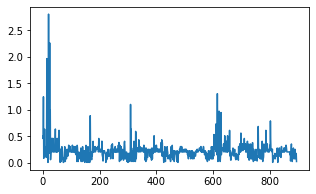

In [17]:
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(df_features.to_numpy()[:-5,0])

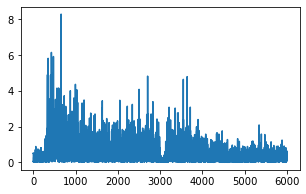

In [18]:
smoothed_emg_df = butterworth_low_pass_filter(df_features.to_numpy(),
                                             frequency=5000,
                                             lp_filter=25)
plt.plot(df_features.to_numpy()[0])
#plt.plot(smoothed_emg_df[0])

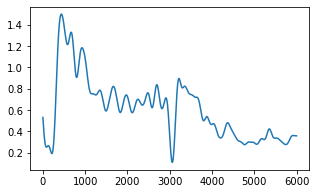

In [19]:
plt.plot(smoothed_emg_df[0])

In [20]:
pca = PCA(n_components=2).fit(smoothed_emg_df.T)
transformed = pca.components_.T

In [21]:
""" Split EMG dataset into training and testing
"""

pca = PCA(n_components=2).fit(smoothed_emg_df.T)
transformed = pca.components_.T
X_train, X_test, y_train, y_test = train_test_split(transformed, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=5)

In [17]:
""" SVM Classification Results
"""

p = make_pipeline(StandardScaler(), SVC())
clf = GridSearchCV(estimator=p, param_grid={'svc__C': np.logspace(-3, 2, 6), 
                                                     'svc__kernel': ['rbf', 'linear'],
                                                     'svc__degree': [1,2],
                                                     'svc__gamma': np.logspace(-3, 2, 6)
                                                    }, 
                                                      cv=5, refit=True, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)

svm_labels = clf.predict(X_test)

(svm_labels == y_test).value_counts()/len(X_test)

False    0.544444
True     0.455556
Name: label, dtype: float64

In [181]:
clf.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10.0, degree=1, gamma=0.1))])

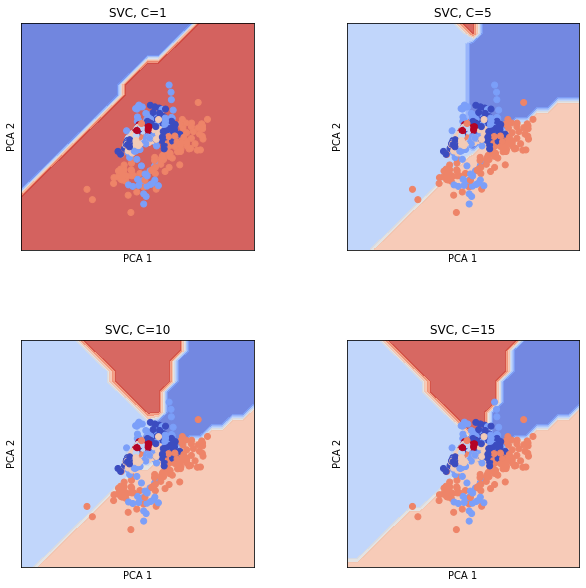

In [22]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_alt = le.transform(y_train)
h = .02 

svc1 = SVC(kernel='linear', C=1).fit(X_train, y_train_alt)
svc2 = SVC(kernel='linear', C=5).fit(X_train, y_train_alt)
svc3 = SVC(kernel='linear', C=10).fit(X_train, y_train_alt)
svc4 = SVC(kernel='linear', C=15).fit(X_train, y_train_alt)

# create a mesh to plot in
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

x_min /= 5
x_max /= 5
y_min /= 5
y_max /= 5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC, C=1',
          'SVC, C=5',
          'SVC, C=10',
          'SVC, C=15']

plt.rcParams["figure.figsize"] = (10,10)

for i, clf in enumerate((svc1, svc2, svc3, svc4)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_train[:, 0], 
                X_train[:, 1], 
                c=y_train_alt, 
                cmap=plt.cm.coolwarm)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

In [359]:
""" KMeans unsupervised learning
"""

accs = []

for i in range(10):
    pca = PCA(n_components=2).fit(smoothed_emg_df.T)
    transformed = pca.components_.T
    X_train, X_test, y_train, y_test = train_test_split(transformed, 
                                                        df_labels, 
                                                        test_size=0.2, 
                                                        random_state=i)
    kmeans = KMeans(n_clusters=len(LABELS)).fit(X_train)

    kmeans.labels_
    predicted_labels = kmeans.predict(X_test)
    predicted_labels

    acc = 1 - (sum([abs(i[0] - i[1]) for i in zip(sorted(np.bincount(le.transform(y_test))), 
                                       sorted(np.bincount(predicted_labels)))])/len(y_test))
    accs.append(acc)
    

print(accs)
print("K-Means stddev",np.std(accs))
print("K-Means best", np.max(accs))

[0.28888888888888886, 0.4111111111111111, 0.4222222222222223, 0.47777777777777775, 0.4444444444444444, 0.4111111111111111, 0.47777777777777775, 0.5555555555555556, 0.4111111111111111, 0.47777777777777775]
K-Means stddev 0.06577177149754997
K-Means best 0.5555555555555556


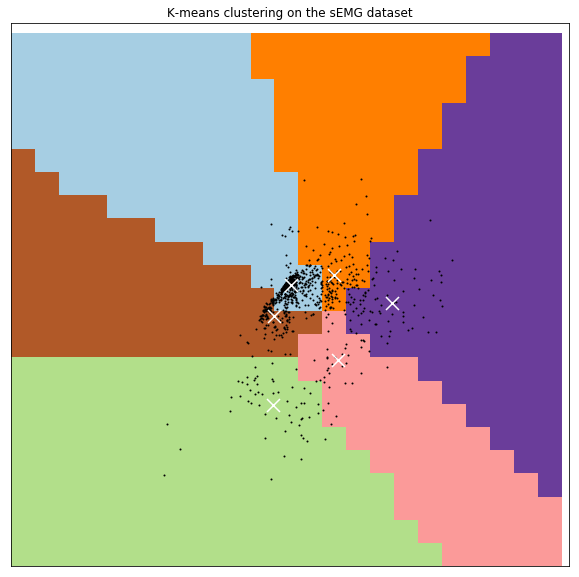

In [230]:
""" Code taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
"""

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

reduced_data = transformed

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

x_min /= 5
x_max /= 5
y_min /= 5
y_max /= 5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the sEMG dataset')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

[0.5777777777777777, 0.8333333333333334, 0.6222222222222222, 0.7, 0.4666666666666667, 0.7444444444444445, 0.6555555555555556, 0.8555555555555556, 0.5, 0.7888888888888889]
Standard dev 0.12756504029777455
Best GM accuracy 0.8555555555555556


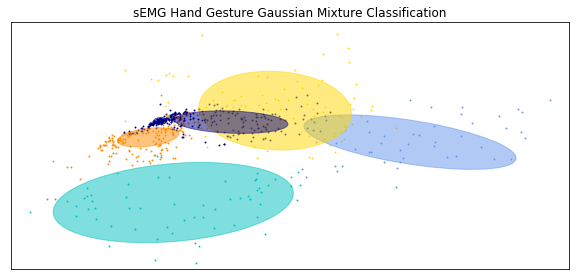

In [361]:
import itertools
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
from scipy import linalg
import matplotlib as mpl
def plot_results(X, Y_, means, covariances, index, title):
    plt.rcParams["figure.figsize"] = (10,10)
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-.05, 0.14)
    plt.ylim(-.15, 0.1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    
""" GM Classification Results
"""
import math
from sklearn.mixture import GaussianMixture as GMM

accs =[]
for i in range(10):
    pca = PCA(n_components=3).fit(smoothed_emg_df.T)
    transformed = pca.components_.T
    X_train, X_test, y_train, y_test = train_test_split(transformed, 
                                                        df_labels, 
                                                        test_size=0.2, 
                                                        random_state=i)

    gmm = GMM(n_components=6).fit(X_train)
    labels = gmm.predict(X_test)
    acc = 1 - (sum([abs(i[0] - i[1]) for i in zip(sorted(np.bincount(le.transform(y_test))), 
                                       sorted(np.bincount(labels)))])/len(y_test))
    accs.append(acc)

plot_results(X_train, gmm.predict(X_train), gmm.means_, gmm.covariances_, 0, 'sEMG Hand Gesture Gaussian Mixture Classification')
print(accs)
print("Standard dev", np.std(accs))
print("Best GM accuracy", np.max(accs))

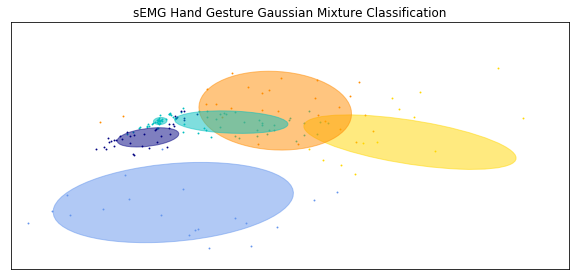

In [362]:
plot_results(X_test, gmm.predict(X_test), gmm.means_, gmm.covariances_, 0, 'sEMG Hand Gesture Gaussian Mixture Classification')

In [104]:
dict(zip(sorted(np.bincount(le.transform(y_test))), 
                                   sorted(np.bincount(labels))))

{24: 7, 25: 13, 31: 23, 32: 42, 36: 57}

In [340]:
""" NB Classification Rules
"""

accs = []

for i in range(10):
    pca = PCA(n_components=2).fit(smoothed_emg_df.T)
    transformed = pca.components_.T
    X_train, X_test, y_train, y_test = train_test_split(transformed, 
                                                        df_labels, 
                                                        test_size=0.2, 
                                                        random_state=i)

    gnb = make_pipeline(StandardScaler(),
                        GaussianNB())
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    accs.append((y_test != y_pred).sum() / X_test.shape[0])

#print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Accuracy", accs)
print(np.std(accs))
print("Best accuracy", np.max(accs))

Accuracy [0.5111111111111111, 0.5333333333333333, 0.5111111111111111, 0.5277777777777778, 0.45555555555555555, 0.5944444444444444, 0.5555555555555556, 0.55, 0.5444444444444444, 0.5222222222222223]
0.03426926780731364
Best accuracy 0.5944444444444444
